<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

# Import usuals libraries

In [ ]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from sklearn.metrics import f1_score , classification_report , accuracy_score , confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, SimpleRNN ,  Flatten, Dense, Dropout, LSTM, BatchNormalization , Input
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# We will have to classify the texts as Spam or Ham, meaning that Spam detection is a case of a Text Classification problem. So, we will be performing EDA on our dataset and building a text classification model.

# Import and load dataset


In [ ]:
dataset = pd.read_csv("/content/spam.csv",encoding='ISO-8859-1')
dataset.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
dataset.shape

(5572, 5)

# EDA


In [ ]:
# Let's take the columns we're interested in

#dropping null values
dataset = dataset.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
dataset.rename(columns = {"v1" : "target", "v2":"Mail"},inplace = True)
dataset.head()


,target,Mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
dataset.describe()

,target,Mail
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
dataset['numeric_target']=dataset["target"].apply(lambda x:1 if x=='spam' else 0)
dataset.head()

,target,Mail,numeric_target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


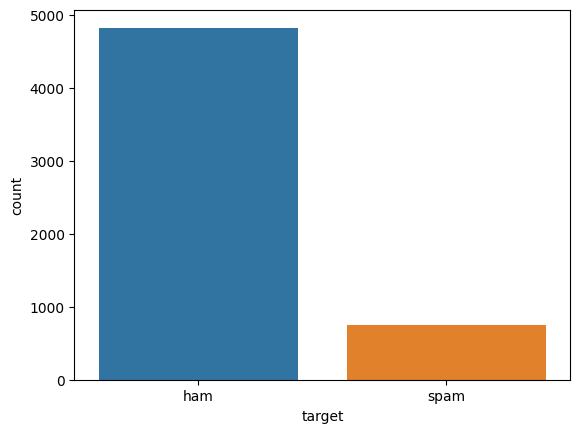

In [ ]:
sns.countplot(x='target', data=dataset)
plt.show()

In [ ]:
# one way to fix it is to downsample the ham msg
ham_dataset = dataset[dataset.target == 'ham'].sample(n = len(dataset[dataset.target =='spam']), random_state = 44)
spam_dataset = dataset[dataset.target =='spam']

In [ ]:
print(ham_dataset.shape, spam_dataset.shape)

(747, 3) (747, 3)


In [ ]:
# Create a dataframe with these ham and spam msg
new_dataset = ham_dataset.append(spam_dataset).reset_index(drop=True)
new_dataset.head()

,target,Mail,numeric_target
0,ham,"Yes, princess. Toledo.",0
1,ham,Dude while were makin those weirdy brownies my...,0
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",0
3,ham,Then u ask darren go n pick u lor... But i oso...,0
4,ham,Lol no. I just need to cash in my nitros. Hurr...,0


In [ ]:
!python -m spacy download en_core_web_sm -q

2023-07-18 07:37:40.783703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Let's see word cloud !

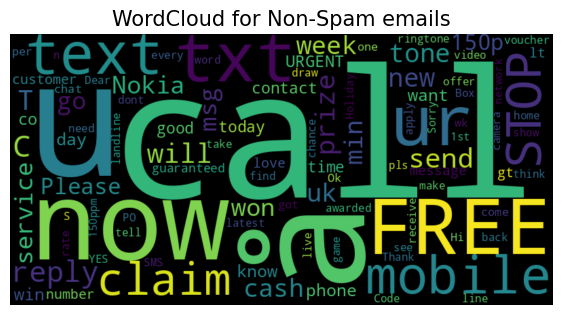

In [ ]:
def show_word_cloud(data, typ):
    email_corpus = " ".join(new_dataset['Mail'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

show_word_cloud(new_dataset[new_dataset['target'] == "ham"], typ='Non-Spam')


### Ham message WordCloud above shows that words like "how", "call", "free", "mobile", etc are most commonly appeared word in ham message.


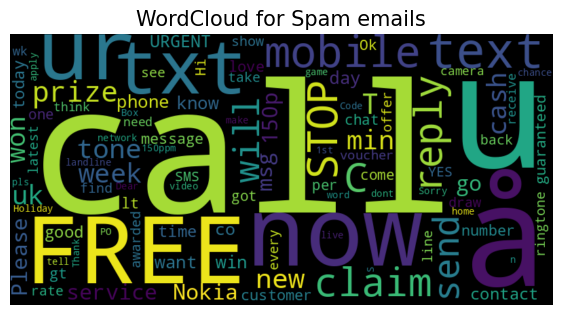

In [ ]:
show_word_cloud(new_dataset[new_dataset['target'] == "spam"], typ='Spam')

###Spam message WordCloud above shows that words "Free", "call", "now","text", etc are most commonly appeared word in spam message.

#DATA PREPROCESSING

###Removing stopwords like 'where', 'why', 'how', 'all', 'any', 'both', 'each' and punctuation symbols is essential before text based predictions. These symbols have an impact on the prediction accuracy if not removed.

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
new_dataset["Mail_clean"] = new_dataset["Mail"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
new_dataset["Mail_clean"] = new_dataset["Mail_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
new_dataset["Mail_clean"] = new_dataset["Mail_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

new_dataset.head()

,target,Mail,numeric_target,Mail_clean
0,ham,"Yes, princess. Toledo.",0,yes princess toledo
1,ham,Dude while were makin those weirdy brownies my...,0,dude makin weirdy brownie sister awesome cooki...
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",0,hiya sorry hav signal hear unusual case sort h...
3,ham,Then u ask darren go n pick u lor... But i oso...,0,u ask darren n pick u lor oso sian tmr haf 2 m...
4,ham,Lol no. I just need to cash in my nitros. Hurr...,0,lol need cash nitros hurry come crash


In [ ]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it indicates we are only going to look for 50 words in a sentence
padding_type = "post" # pad_sequences parameter
oov_tok = "out_of_vocab" # out of vocabulary token
vocab_size = 5000

In [ ]:
#Create and fit a tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= vocab_size, oov_token= oov_tok) # instanciate the tokenizer
tokenizer.fit_on_texts(new_dataset.Mail_clean)
new_dataset["Mail_encoded"] = tokenizer.texts_to_sequences(new_dataset.Mail_clean)

new_dataset["len_text"] = new_dataset["Mail_encoded"].apply(lambda x: len(x))
new_dataset = new_dataset[new_dataset["len_text"]!=0]
print(tokenizer.word_index)


{'out_of_vocab': 1, 'u': 2, 'free': 3, '2': 4, 'ur': 5, 'txt': 6, 'text': 7, '4': 8, 'mobile': 9, 'win': 10, 'stop': 11, 'reply': 12, 'claim': 13, 'send': 14, 'prize': 15, 'new': 16, 'tone': 17, 'week': 18, 'service': 19, 'phone': 20, 'know': 21, 'want': 22, 'good': 23, 'nokia': 24, 'award': 25, 'cash': 26, 'urgent': 27, 'contact': 28, 'day': 29, 'come': 30, 'time': 31, 'today': 32, 'min': 33, 'customer': 34, 'message': 35, 'guarantee': 36, 'number': 37, 'love': 38, 'try': 39, '16': 40, 'ok': 41, 'late': 42, 'ltgt': 43, 'think': 44, 'chat': 45, 'like': 46, '18': 47, 'hi': 48, 'tell': 49, 'r': 50, '1': 51, 'draw': 52, 'line': 53, 'receive': 54, 'offer': 55, '3': 56, 'need': 57, 'voucher': 58, 'msg': 59, 'å1000': 60, 'c': 61, 'holiday': 62, '150ppm': 63, 'landline': 64, 'live': 65, 'box': 66, 'camera': 67, 'find': 68, 'dear': 69, 'yes': 70, 's': 71, 'm': 72, 'ringtone': 73, 'å2000': 74, 'sorry': 75, 'end': 76, 'rate': 77, 'cost': 78, 'po': 79, 'chance': 80, 'video': 81, 'meet': 82, 'date

In [ ]:
new_dataset.sample(10)[['Mail','Mail_clean','Mail_encoded','target','numeric_target']]

,Mail,Mail_clean,Mail_encoded,target,numeric_target
1014,"FreeMsg Hey U, i just got 1 of these video/pic...",freemsg hey u 1 videopic fone reply wild txt ...,"[257, 112, 2, 51, 3311, 434, 12, 3312, 6, 360,...",spam,1
171,Me too watching surya movie only. . .after 6 p...,watch surya movie 6 pm vijay movie pokkiri,"[288, 2072, 479, 328, 573, 2073, 479, 2074]",ham,0
49,"K, want us to come by now?",k want come,"[319, 22, 30]",ham,0
1003,Hottest pics straight to your phone!! See me g...,hot pic straight phone wet want xx text pic 89...,"[160, 110, 1648, 20, 869, 22, 500, 7, 110, 102...",spam,1
109,I hate when she does this. She turns what shou...,hate turn fun shopping trip annoying day look ...,"[880, 881, 230, 292, 324, 1174, 29, 130, 418]",ham,0
1156,This message is free. Welcome to the new & imp...,message free welcome new improved sex dog ...,"[35, 3, 310, 16, 1718, 286, 298, 157, 156, 19,...",spam,1
641,I though we shd go out n have some fun so bar ...,shd n fun bar town ûò sound ok,"[2758, 94, 230, 1346, 249, 608, 723, 41]",ham,0
1074,Download as many ringtones as u like no restri...,download ringtone u like restriction 1000s 2 c...,"[442, 73, 2, 46, 3405, 1088, 4, 222, 2, 14, 4,...",spam,1
9,Should I tell my friend not to come round til ...,tell friend come round til like ltgt ish,"[49, 100, 30, 842, 671, 46, 43, 843]",ham,0
703,Ok u can take me shopping when u get paid =D,ok u shop u pay d,"[41, 2, 251, 2, 183, 121]",ham,0


In [ ]:
pad_array = tf.keras.preprocessing.sequence.pad_sequences(new_dataset['Mail_encoded'], padding= padding_type)
pad_array

array([[  70,  469, 1828, ...,    0,    0,    0],
       [ 666, 1829, 1830, ...,    0,    0,    0],
       [1833,   75,  668, ...,    0,    0,    0],
       ...,
       [ 568,    9,  612, ...,    0,    0,    0],
       [ 912,  651,  655, ...,    0,    0,    0],
       [ 132,   31,   39, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X = pad_array
y = new_dataset["numeric_target"].values

In [ ]:
#from tensorflow.keras.utils import to_categorical

#y = to_categorical(y)

In [ ]:
# Split data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=10)
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)

X_train.shape: (1043, 37)
X_val.shape: (448, 37)
y_train.shape: (1043,)
y_val.shape: (448,)


In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
train_batch = train.shuffle(len(X_train)).batch(64)
val_batch = val.shuffle(len(X_val)).batch(64)

In [ ]:
embeding_dim = 8
#drop_value = 0.2 # dropout
#n_dense = 24
#input_length=(train_batch.shape[-1]

In [ ]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, name="embeding"))
#model.add(Flatten()) # Tensor in 1D
model.add(GlobalAveragePooling1D())
model.add(Dense(units=16, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(units=1 , activation='sigmoid'))

In [ ]:
display(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeding (Embedding)        (None, None, 8)           40000     
                                                                 
 global_average_pooling1d_2   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 40,161
Trainable params: 40,161
Non-trainable params: 0
_________________________________________________________________


None

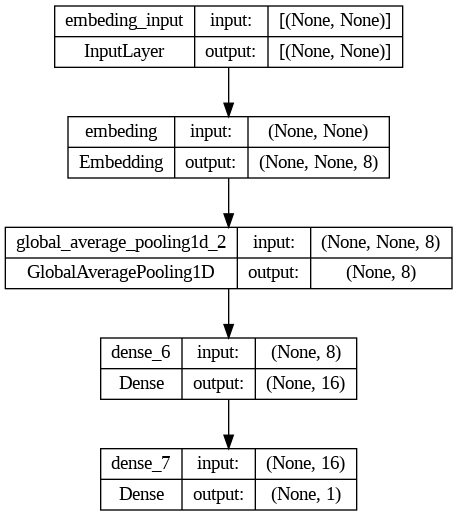

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_batch , epochs=30 , validation_data=val_batch)

Epoch 1/30
17/17 [==============================] - 1s 12ms/step - loss: 0.6926 - accuracy: 0.4871 - val_loss: 0.6916 - val_accuracy: 0.4643
Epoch 2/30
17/17 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5139 - val_loss: 0.6890 - val_accuracy: 0.4643
Epoch 3/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5197 - val_loss: 0.6837 - val_accuracy: 0.4821
Epoch 4/30
17/17 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5858 - val_loss: 0.6743 - val_accuracy: 0.5625
Epoch 5/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6884 - val_loss: 0.6624 - val_accuracy: 0.6741
Epoch 6/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.7613 - val_loss: 0.6462 - val_accuracy: 0.7143
Epoch 7/30
17/17 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.8169 - val_loss: 0.6223 - val_accuracy: 0.7946
Epoch 8/30
17/17 [=

In [ ]:
history_dense = model.history.history

In [ ]:
history_dense.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
metrics = pd.DataFrame(history_dense)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.692619,0.487057,0.691552,0.464286
1,0.688648,0.513902,0.689043,0.464286


In [ ]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                          'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.692619,0.487057,0.691552,0.464286
1,0.688648,0.513902,0.689043,0.464286


In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

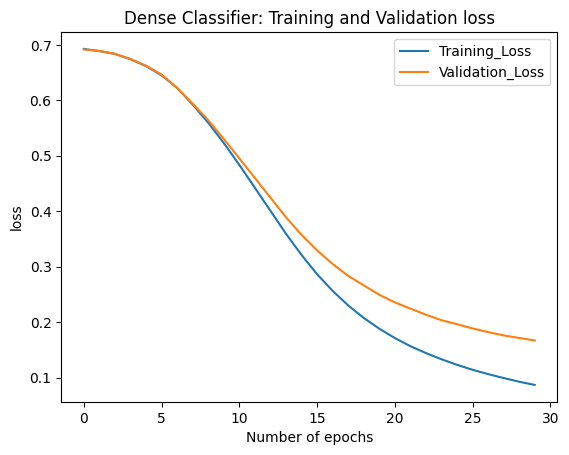

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

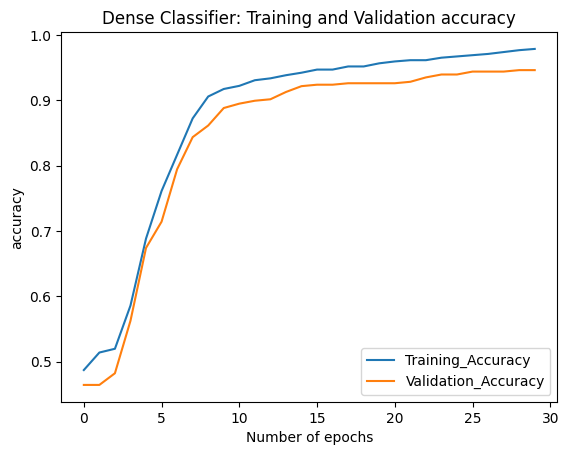

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    pad = pad_sequences(new_seq, maxlen =X_train.shape[-1],
                      padding = padding_type)
    return (model.predict(pad))

In [ ]:
predict_msg = ["You are awarded a Nikon Digital Camera, please Call now to receive your gift",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 22ms/step


array([[0.6933125],
       [0.0952084],
       [0.0952084]], dtype=float32)

In [ ]:
preds = list(model.predict(X_val).reshape(1,-1)[0])
preds = [int(pred) for pred in preds]


14/14 [==============================] - 0s 4ms/step
